# Downloads and Imports

In [ ]:
"""
This notebook provides an example usage of the functions in the utils folder.
"""

In [18]:
%%capture
import nltk
import pandas as pd
import urllib.request
import json
from difflib import ndiff
from collections import Counter
from nltk.corpus import wordnet as wn
import pandas as pd
import os
pd.options.mode.chained_assignment = None
nltk.download('wordnet')

In [2]:
import sys
sys.path.append('../')

from utils.tools import DistanceTools
from utils.setup import SetupFunctions
from utils.evaluation import Evaluation

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [181]:
setup = SetupFunctions()
evals = Evaluation()
tools = DistanceTools()

In [177]:
def createData(link, filename = "../data//data.dat"):

  """
  This function downloads the data from the link and saves it locally. The files that can be parsed have the structure 
  $correct_word
  incorrect_word
  incorrect_word 
  .
  .
  .
  It scans for duplicate correct words and prints them too
  It returns a dataframe with the columns 'words' and 'mispellings' and a list of repeats(for the stats)  
  
  """
  urllib.request.urlretrieve(link, filename)
  current_key = None
  result_dict = {}
  repeats = []
  #print('About the spellcheck dataset:\n')
  for line in open(filename).readlines():

      lines = line.strip().split('\n')

      if lines[0].startswith('$'):
              current_key = lines[0][1:].lower()
              if(current_key not in result_dict.keys()):
                  result_dict[current_key] = []
              else:
                #print('The word "' + current_key + '" occurs more than once')
                repeats.append(current_key)
                #result_dict[current_key].append(lines[0].lower())
              #print(line[1:-2])
              #result_dict[current_key] = []
      else:
              result_dict[current_key].append(lines[0].lower())

  df = pd.DataFrame([result_dict.keys(), result_dict.values()]).T
  df.columns = ['words', 'misspellings']

  return df, repeats

# For parallel processing

In [5]:
from pandarallel import pandarallel
pandarallel.initialize(nb_workers = 300)

INFO: Pandarallel will run on 300 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [178]:
def findingClosestWords(start_index = 0, end_index = 10, df =None, 
                        k_vals = [1,5,10], 
                        link =  "https://www.dcs.bbk.ac.uk/~roger/missp.dat"):
  
  """
  This function calls all the functions to evaluate the dataset and saves the result in the examples folder.

  """

  tools = DistanceTools()
  repeats = []
  if (df is None):
    df, repeats = createData(link = link)  #can mention filename and link here

  df, starters = setup.findPossibleFirstLetters(df)
  dictionary, word_count = setup.buildDictionary()
  setup.describeData(df, repeats, word_count)
  df1 = df[start_index : end_index]
  df1['k_list'] = df1.parallel_apply(lambda x: tools.find_k(x.words, x.misspellings, dictionary, starters), axis = 1)
  results = evals.getResults(df1)
  print('\n')
  success_at_k = evals.getAverageSuccessValues(results, df1.num_of_words.sum(), k_vals)
  df1.drop(columns = ['num_of_words'], inplace = True)
  df1.to_json('spellCheck.json')
  with open("evalResults.json", "w") as fp:
    json.dump(success_at_k, fp)
  print('-----------------------------------------------------------------------------------------------------')
  return df1

In [182]:
"""
Mentioning the other links also in the dictionary. The aspell and wikipedia datasets are also in the same format 
and hence can be imported here. The s@k values (values for k can be mentioned in the k_vals parameter) are printed 
and also saved to the json file.
"""
links = { 'birkbeck' : 'https://www.dcs.bbk.ac.uk/~roger/missp.dat',
        'aspell' : 'https://www.dcs.bbk.ac.uk/~roger/aspell.dat',
        'wikipedia' : 'https://www.dcs.bbk.ac.uk/~roger/wikipedia.dat' }

k_values = findingClosestWords(start_index = 1, end_index = 5, k_vals = [1,5,10], link = links['birkbeck'])


There are a total of 6130 unique correct words and 6 repeats which totals to 6136 words
There are a total of 36133 misspelt words in the dataset

About the wordnet dictionary:

There are 147306 words in the wordnet dictionary

k = 1 in 5 search(es)


Success at 1 is 100.0 %
Success at 5 is 100.0 %
Success at 10 is 100.0 %
-----------------------------------------------------------------------------------------------------


In [75]:
"""
To reproduce our run on the birkbeck dataset.
The program was run on multiple systems and the results were stored as json files. They are available in resuls\parts
We import the result files here to show the calculation of the s@k metric.

"""


def concatenateParallelRuns(k_vals = [1, 5, 10], link = links['birkbeck']):
  
  df, repeats = createData(link = link)  #can mention filename and link here
  df, starters = setup.findPossibleFirstLetters(df)
  num_of_words = df.num_of_words.sum()
  dictionary, word_count = setup.buildDictionary()
  setup.describeData(df, repeats, word_count)

  df = pd.DataFrame()
  for json_file in os.listdir('../results//birkbeckResults//parts'):
      file_name = '../results//birkbeckResults//parts//' + json_file
      df1 = pd.read_json(file_name)
      df = pd.concat([df, df1])
      
  results = evals.getResults(df)
  print('\n')
  success_at_k = evals.getAverageSuccessValues(results, num_of_words, k_vals)
  df.to_json('../results//birkbeckResults//full//spellCheck.json')
  with open("../results//birkbeckResults//full//evalResults.json", "w") as fp:
    json.dump(success_at_k, fp)
  print('-----------------------------------------------------------------------------------------------------')
  return df,results, starters

In [183]:
df, results, starters = concatenateParallelRuns()


There are a total of 6130 unique correct words and 6 repeats which totals to 6136 words
There are a total of 36133 misspelt words in the dataset

About the wordnet dictionary:

There are 147306 words in the wordnet dictionary

k = 4 in 2501 search(es)
k = 1 in 19162 search(es)
k = 2 in 7151 search(es)
k = 5 in 1376 search(es)
k = 3 in 4184 search(es)
k = 7 in 418 search(es)
k = 6 in 756 search(es)
k = 10 in 78 search(es)
k = 8 in 245 search(es)
k = 9 in 149 search(es)
k = 11 in 48 search(es)
k = 12 in 33 search(es)
k = 13 in 19 search(es)
k = 16 in 4 search(es)
k = 15 in 1 search(es)
k = 14 in 7 search(es)
k = 17 in 1 search(es)


Success at 1 is 53.03 %
Success at 5 is 95.13 %
Success at 10 is 99.69 %
-----------------------------------------------------------------------------------------------------


In [136]:
"""
Some visualizationns on the data.
This process was to find mistaken starting words and visualizing stats is always fun

"""
import seaborn as sns
import matplotlib.pyplot as plt

startersdf = pd.concat({k: pd.Series(v) for k, v in starters.items()}).reset_index()
startersdf.columns = ['mistaken_as', 'instead_of_count', 'instead_of']
startersdf = startersdf.groupby(['mistaken_as']).agg({'instead_of_count': 'max',
                                    'instead_of': list}).reset_index(drop = False)

Text(0.5, 1.0, 'Most mistaken starting letters')

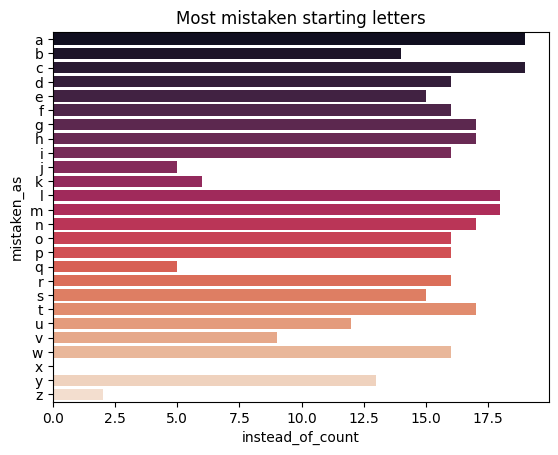

In [137]:
fig = sns.barplot(startersdf[1:27],
            x = "instead_of_count",
            y ="mistaken_as",
            hue = "mistaken_as",
            palette = 'rocket')
fig.set_title('Most mistaken starting letters')
#plt.savefig('Stats', bbox_inches='tight')

In [142]:
df = pd.DataFrame(results, index = results.keys())
df.drop(df.columns[1:], inplace=True)
df = df.T.reset_index()
df.columns = ['k_Value', 'Number_of_words']

In [143]:
df.head()

,k_Value,Number_of_words
0,4,2501
1,1,19162
2,2,7151
3,5,1376
4,3,4184


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17468\2145120829.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fig = sns.barplot(df[0:10],


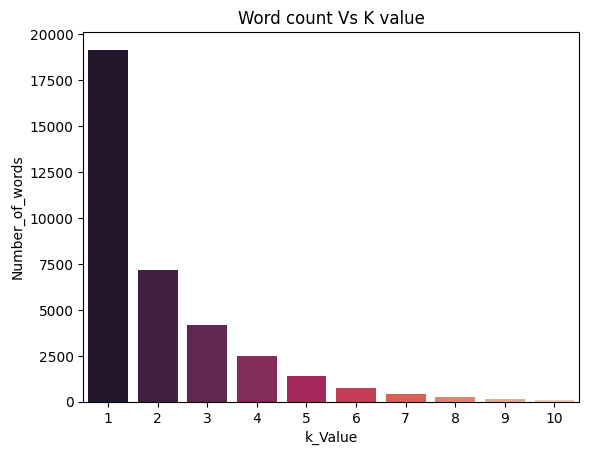

In [73]:
fig = sns.barplot(df[0:10],
            x="k_Value",
            y="Number_of_words",
            #hue = "k_Value",
            palette = 'rocket')
fig.set_title('Word count Vs K value')
plt.savefig('Stats', bbox_inches='tight')


In [157]:

"""
We needed to print an example for the report so minor changes were made to the findTarget function in tools.

"""
def findExample(target, word):
    
    df, repeats = createData(link = links['birkbeck'])  #can mention filename and link here
    df, starters = setup.findPossibleFirstLetters(df)
    num_of_words = df.num_of_words.sum()
    dictionary, word_count = setup.buildDictionary()

    max_length = len(target) + 10
    max_k = sum(tools.levenshtein_distance_gen(target, word))

    temp = set([max_k])
    #print('The target is:', target)
    #print('The misspelt word is:', word)
    #print('Worst case k: ', max_k)
    close = {}
    close[max_k] = [target]
    if(max_k == 1):
      #print('k value is: ', max_k)
      return 1, close

    
    for start_letter in starters[word[0]]:
      #print('checking words starting with: ', start_letter)
      for w in dictionary[start_letter]:

        if (len(w) <= max_length):

            t = sum(tools.levenshtein_distance_gen(word, w))
            if (t < max_k and t > 0):
              #print('The check word is: '+ w +' , distance: ' + str(t))
              try:
                close[t].append(w)
              except:
                close[t] = [w]
              temp.add(t)

            if(len(temp) == max_k):
              #print(temp)
              #print('k value is: ', max_k)

              return max_k, close
        else:
          break
    #print(temp)
    #print('k value is: ', len(temp))
    return len(temp), close

In [188]:
target = 'accrued'
check = 'acrood'
k_value, close_words = findExample(target, check)

In [197]:
print('The rank of the target word "'+ target + '" when it is misspelled as "' + check + '" is ' +str(k_value) + 
      '\nWe found words with distance(s) '+ str(list(close_words.keys())) + ' from "'+ target + '", which explains the rank.')
print('\nWords with distances:\n')
print('Target: "'+ target +'"')
for i in close_words.keys():
    print('Distance:' + str(i)+ ' ; Words: ' + str(close_words[i]))

The rank of the target word "accrued" when it is misspelled as "acrood" is 2
We found words with distance(s) [3, 2] from "accrued", which explains the rank.

Words with distances:

Target: "accrued"
Distance:3 ; Words: ['accrued']
Distance:2 ; Words: ['acrid', 'acold', 'aroid', 'abroad', 'across', 'rood', 'croon', 'crook', 'crowd', 'scrod', 'brood']
